# Loading the Dataset

In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Lichess/tournament-chess-games")
ds

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle', 'WhiteFideId', 'BlackFideId', 'WhiteElo', 'BlackElo', 'UTCDate', 'UTCTime', 'ECO', 'Opening', 'Termination', 'TimeControl', 'Board', 'Variant', 'StudyName', 'ChapterName', 'BroadcastName', 'BroadcastURL', 'GameURL', 'movetext'],
        num_rows: 733234
    })
})

In [2]:
columns = list(ds['train'].features.keys())
columns.remove('WhiteElo')
columns.remove('BlackElo')
columns.remove('movetext')
columns.remove('Variant')

In [3]:
ds['train'] = ds['train'].remove_columns(columns)
ds

DatasetDict({
    train: Dataset({
        features: ['WhiteElo', 'BlackElo', 'Variant', 'movetext'],
        num_rows: 733234
    })
})

# Processing the Dataset

### Selecting a Subset

In [4]:
import pandas as pd

df = pd.DataFrame(ds['train'][:])
df.dropna(how='any', inplace=True)
df

,WhiteElo,BlackElo,Variant,movetext
0,2578.0,2584.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:43] } 1... Nf6...
1,2584.0,2578.0,Standard,1. e4 { [%eval 0.24] [%clk 1:30:54] } 1... e5 ...
2,2578.0,2584.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:40] } 1... Nf6...
3,2584.0,2578.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:56] } 1... d5 ...
4,2578.0,2584.0,Standard,1. c4 { [%eval 0.16] [%clk 1:30:49] } 1... Nf6...
...,...,...,...,...
733229,1979.0,1874.0,Standard,1. d4 { [%eval 0.17] [%clk 1:30:59] } 1... Nf6...
733230,1951.0,1810.0,Standard,1. e4 { [%eval 0.18] [%clk 1:30:57] } 1... c5 ...
733231,1825.0,1948.0,Standard,1. e4 { [%eval 0.18] [%clk 1:30:25] } 1... c6 ...
733232,1758.0,1940.0,Standard,1. d4 { [%eval 0.17] [%clk 1:30:57] } 1... d5 ...


In [5]:
df.describe()

,WhiteElo,BlackElo
count,5.455570e+05,5.455570e+05
mean,2.076021e+03,2.080754e+03
std,7.221848e+03,1.018806e+04
min,0.000000e+00,0.000000e+00
25%,1.831000e+03,1.828000e+03
50%,2.120000e+03,2.116000e+03
75%,2.384000e+03,2.382000e+03
max,5.324491e+06,5.327130e+06


In [ ]:
idx = df['WhiteElo'] >= 2000
print(f'Percentage of gamse with (WhiteElolen >= 2000): {(len(df[idx]) / len(df)):.2%}')

Percentage of gamse with (WhiteElolen >= 2000): 60.56%


In [ ]:
df = df[df['Variant'] == 'Standard']
og_len = len(df)
df = df[df['WhiteElo'] >= 2000] 
df = df[df['BlackElo'] >= 2000]
print(f'Percentage of remaining dataset: {len(df) / og_len:.2%}')

Percentage of remaining dataset: 50.08%


In [8]:
df = df.drop(columns=['Variant', 'WhiteElo', 'BlackElo'])

In [9]:
df.loc[0]

movetext    1. d4 { [%eval 0.25] [%clk 1:30:43] } 1... Nf6...
Name: 0, dtype: object

### Transform movetext to Standard PGN

In [10]:
import re

def clean_movetext(row):
    text = row['movetext']
    cleaned = re.sub(r"\{.*?\}", "", text) 
    cleaned = re.sub(r"[\?!]+", "", cleaned)
    cleaned = re.sub(r"\d+\.\.\.", "", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    return cleaned


In [11]:
df['movetext'] = df.apply(clean_movetext, axis=1)
df

,movetext
0,1. d4 Nf6 2. c4 e6 3. Nf3 d5 4. Nc3 Be7 5. g3 ...
1,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nf6 4. O-O Nxe4 5. ...
2,1. d4 Nf6 2. c4 e6 3. Nf3 d5 4. Nc3 c5 5. cxd5...
3,1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4...
4,1. c4 Nf6 2. Nc3 e6 3. e4 d5 4. cxd5 exd5 5. e...
...,...
733198,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. d3 Bc5 5. c3...
733219,1. e4 c6 2. Nf3 d5 3. exd5 cxd5 4. Ne5 Nc6 5. ...
733220,1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. e3 O-O 5. Bd3...
733221,1. e4 c5 2. Nf3 e6 3. d4 cxd4 4. Nxd4 Nc6 5. N...


### Game Lenghth Distribution

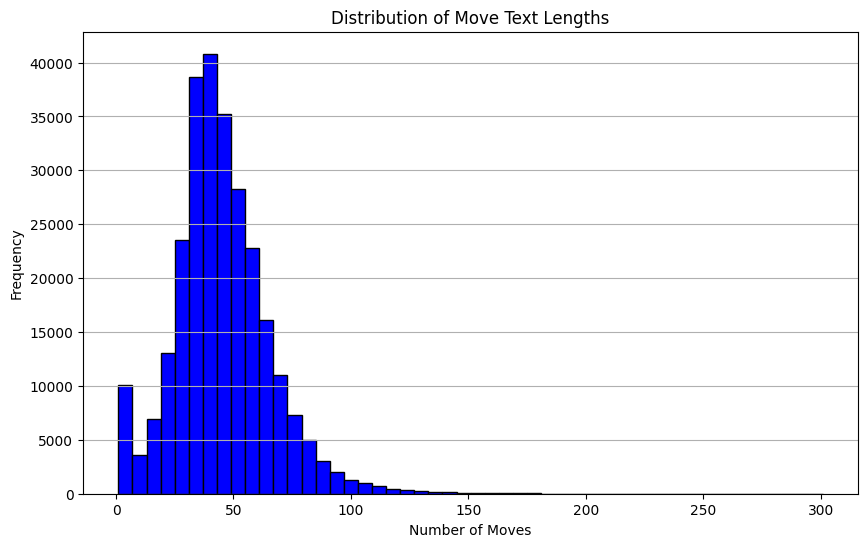

In [12]:
import matplotlib.pyplot as plt

df['length'] = df['movetext'].apply(lambda x: len(x.split('.')))

plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Move Text Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [13]:
df.drop(columns=['length'], inplace=True)

### Splitting the Dataset

In [14]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.25, random_state=42)
train_df

,movetext
352233,1. e4 e6 2. d4 d5 3. exd5 exd5 4. Nf3 c6 5. Bd...
148771,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nf6 4. O-O Nxe4 5. ...
529894,1. e4 c5 2. Ne2 d6 3. g3 g6 4. Bg2 Bg7 5. c3 e...
579124,1. e4 e6 2. d4 d5 3. Nc3 Bb4 4. e5 b6 5. a3 Bf...
628698,1. f4 d5 2. Nf3 c5 3. g3 Nc6 4. Bg2 g6 5. O-O ...
...,...
330688,1. Nf3 Nf6 2. c4 g6 3. Nc3 c5 4. d4 cxd4 5. Nx...
706393,1. e4 e5 2. Nf3 Nc6 3. d4 exd4 4. Bc4 Nf6 5. e...
357511,1. e4 c5 2. Nf3 Nc6 3. d4 cxd4 4. Nxd4 g6 5. c...
400833,1. d4 Nf6 2. c4 g6 3. Nc3 Bg7 4. e4 d6 5. Be2 ...


### Transforming the Dataset back

In [15]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
ds = DatasetDict({
    'train': train_ds,
    'valid': valid_ds
})

### Extracting Individual Turns from each Game

In [16]:
import chess
import chess.pgn

def extract_turns(row):
    positions = []
    moves = []

    text = row['movetext'][0]
    with open('tmp.pgn', 'w') as f:
        f.write(text)

   
    pgn = open("tmp.pgn")
    game = chess.pgn.read_game(pgn)
    if game.errors:
        return {"positions": [], "moves": []}
    else:
        pass
    
    board = game.board()

    for move in game.mainline_moves():
        if board.turn:
            pos = 'WHITE'
            if chess.Move.from_uci("e1g1") in board.legal_moves:
                pos = pos + ' ' + 'KINGSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_KINGSIDE_CASTLE'
            if chess.Move.from_uci("e1c1") in board.legal_moves:
                pos = pos + ' ' + 'QUEENSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_QUEENSIDE_CASTLE'

        else:
            pos = 'BLACK'

            if chess.Move.from_uci("e8g8") in board.legal_moves:
                pos = pos + ' ' + 'KINGSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_KINGSIDE_CASTLE'
            if chess.Move.from_uci("e8c8") in board.legal_moves:
                pos = pos + ' ' + 'QUEENSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_QUEENSIDE_CASTLE'
        
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                pos = pos + ' ' + piece.symbol()
            else:
                pos = pos + ' ' + 'EMPTY'

        board.push(move)
        positions.append(pos)
        moves.append(move.uci())


    return {'positions': positions, 'moves': moves}

ds = ds.map(extract_turns, batched=True, batch_size=1, remove_columns=['movetext', '__index_level_0__'])
    

Map:   0%|          | 0/203883 [00:00<?, ? examples/s]

illegal san: 'Ke5' in 8/5p1p/4k3/2bp2Pp/5P2/r1B1P3/4K3/2R5 b - - 6 45 while parsing <Game at 0x7f811d933920 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ke7' in 3Q4/pqrk1p2/1n2N1p1/1p1Pp1B1/1P2P3/P6P/5PP1/4b1K1 b - - 8 34 while parsing <Game at 0x7f81e75507a0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ng6' in rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR b KQkq - 0 1 while parsing <Game at 0x7f81e7550950 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Kd7' in 3k4/R7/8/3K4/5b2/8/8/8 b - - 24 107 while parsing <Game at 0x7f81e7550950 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Bf2' in rnbqkbnr/pp1p2pp/2p5/3Pp3/2P2p2/5P2/PP2P1PP/RNBQKBNR w KQkq - 0 5 while parsing <Game at 0x7f81e75507a0 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ng3' in rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3 while parsing <Game at 0x7f82287f2b10 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Nd3' in rnbqkbnr/pp2p1pp/2p2p2/3p4/2PP4/1P6/P3PPPP/RNBQKBNR w KQkq - 0 4 while

Map:   0%|          | 0/67961 [00:00<?, ? examples/s]

illegal san: 'Bxc6' in r1bqkbnr/pppppppp/2n5/8/8/6P1/PPPPPP1P/RNBQKBNR w KQkq - 1 2 while parsing <Game at 0x7f82287f2b10 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Kd4' in 7R/pp6/2bk1p1p/2p2B2/7r/2P1K3/8/8 w - - 0 47 while parsing <Game at 0x7f82287f2b10 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ke5' in 8/8/3k4/7p/3RBP2/1r2n3/8/6K1 b - - 1 42 while parsing <Game at 0x7f811d932600 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Kd4' in 5bk1/5p1p/p4Pp1/5b2/5BP1/3rKB2/Pr5P/2R4R w - - 1 30 while parsing <Game at 0x7f811d933410 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ke4' in 8/3n4/8/3k4/8/4K3/8/8 w - - 0 142 while parsing <Game at 0x7f81e7550c20 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ke5' in 1r6/3n4/2pk3p/p2p2pP/3P1pP1/1P1BnP2/1NPK4/R7 b - - 10 39 while parsing <Game at 0x7f811d932450 ('?' vs. '?', '????.??.??' at '?')>
illegal san: 'Ke4' in 8/p4n2/n6P/4k3/8/3K4/8/6R1 w - - 2 51 while parsing <Game at 0x7f81e75ff9b0 ('?' vs. '?', '????.??.??' at '?')>


In [19]:
del df, train_df, valid_df, train_ds, valid_ds

In [20]:
ds

DatasetDict({
    train: Dataset({
        features: ['positions', 'moves'],
        num_rows: 17374365
    })
    valid: Dataset({
        features: ['positions', 'moves'],
        num_rows: 5785475
    })
})

### Pushing to HuggingFace

In [21]:
from huggingface_hub import login

login()

In [ ]:
repo_id = "noor-zalouk/tournament-chess-games"
ds.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/13 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  79%|#######8  | 41.9MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  63%|######3   | 33.5MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  47%|####7     | 25.0MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  79%|#######9  | 41.9MB / 53.0MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  47%|####7     | 25.0MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  47%|####7     | 25.2MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  63%|######3   | 33.5MB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  571kB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 53.0MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 53.1MB            

Creating parquet from Arrow format:   0%|          | 0/1337 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 53.1MB            

{"timestamp":"2025-08-20T18:11:48.346498Z","level":"WARN","fields":{"message":"Status Code: 502. Retrying...","request_id":""},"filename":"/home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs","line_number":236}


Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1158 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 45.9MB            

{"timestamp":"2025-08-20T18:16:10.202812Z","level":"WARN","fields":{"message":"Status Code: 502. Retrying...","request_id":""},"filename":"/home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs","line_number":236}


Creating parquet from Arrow format:   0%|          | 0/1158 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 45.9MB            

Creating parquet from Arrow format:   0%|          | 0/1158 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  570kB / 45.9MB            

Creating parquet from Arrow format:   0%|          | 0/1158 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  572kB / 45.9MB            

Creating parquet from Arrow format:   0%|          | 0/1158 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         |  571kB / 45.9MB            

CommitInfo(commit_url='https://huggingface.co/datasets/noor-zalouk/tournament-chess-games-2000-elo/commit/4149ec53a1936a23dc2b2f899c4639d021a3c9c5', commit_message='Upload dataset', commit_description='', oid='4149ec53a1936a23dc2b2f899c4639d021a3c9c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/noor-zalouk/tournament-chess-games-2000-elo', endpoint='https://huggingface.co', repo_type='dataset', repo_id='noor-zalouk/tournament-chess-games-2000-elo'), pr_revision=None, pr_num=None)